# COMP4211 - Assignment 1

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import re
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import time
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

## Part 1: Data Exploration and Preparation

In [2]:
# Loading the data.

df = pd.read_csv("data.csv")
bonus_df = df.copy()

#### Q1: Dataset Overview

In [3]:
df.head(5)

,c1,c2,c3,c4,c5,c6,c7,c8,c9,reg_target,class_target
0,male,22.0,1,0,A/5 21171,NaN,S,Lower Class,"Braund, Mr. Owen Harris",7.2500,0
1,female,38.0,1,0,PC 17599,C85,C,Upper Class,"Cumings, Mrs. John Bradley (Florence Briggs Th...",71.2833,1
2,female,26.0,0,0,STON/O2. 3101282,NaN,S,Lower Class,"Heikkinen, Miss. Laina",7.9250,1
3,female,35.0,1,0,113803,C123,S,Upper Class,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",53.1000,1
4,male,35.0,0,0,373450,NaN,S,Lower Class,"Allen, Mr. William Henry",8.0500,0


In [4]:
# Number of rows and columns in dataset.

print(f"Shape of dataframe: {df.shape}")

Shape of dataframe: (891, 11)


In [5]:
# Size of dataset (total number of elements in the DataFrame)

print(f"The size of the dataset: {df.size}")

The size of the dataset: 9801


In [6]:
# Missing values for each column.

missing_values = df.isna().sum()
missing_values

c1                0
c2              177
c3                0
c4                0
c5                0
c6              687
c7                2
c8                0
c9                0
reg_target        0
class_target      0
dtype: int64

In [7]:
# Proportion of missing values.

total_values = df.shape[0]


proportion_missing = missing_values / total_values

proportion_missing

c1              0.000000
c2              0.198653
c3              0.000000
c4              0.000000
c5              0.000000
c6              0.771044
c7              0.002245
c8              0.000000
c9              0.000000
reg_target      0.000000
class_target    0.000000
dtype: float64

## Q2: Feature Distribution

#### Numerical Features

In [8]:
# Column data types. 

df.dtypes

c1               object
c2              float64
c3                int64
c4                int64
c5               object
c6               object
c7               object
c8               object
c9               object
reg_target      float64
class_target      int64
dtype: object

In [9]:
# Numerical features.
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Checking for continuous and discrete features
continuous_features = []
discrete_features = []

for col in numerical_features: 
    
    unique_values = df[col].nunique()
    
    # If unique values < 10 we say feature is discrete.
    if unique_values < 10:  
        discrete_features.append(col)
    else: 
        continuous_features.append(col)

# first-in-order numerical feature is c2.
print("Numerical Features:", numerical_features) 
print("Continuous Features:", continuous_features)
print("Discrete Features:", discrete_features)

Numerical Features: ['c2', 'c3', 'c4', 'reg_target', 'class_target']
Continuous Features: ['c2', 'reg_target']
Discrete Features: ['c3', 'c4', 'class_target']


In [10]:
# Summarize statistical distribution of all numerical features.

df[numerical_features].describe()

,c2,c3,c4,reg_target,class_target
count,714.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208,0.383838
std,14.526497,1.102743,0.806057,49.693429,0.486592
min,0.420000,0.000000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400,0.000000
50%,28.000000,0.000000,0.000000,14.454200,0.000000
75%,38.000000,1.000000,0.000000,31.000000,1.000000
max,80.000000,8.000000,6.000000,512.329200,1.000000


c2


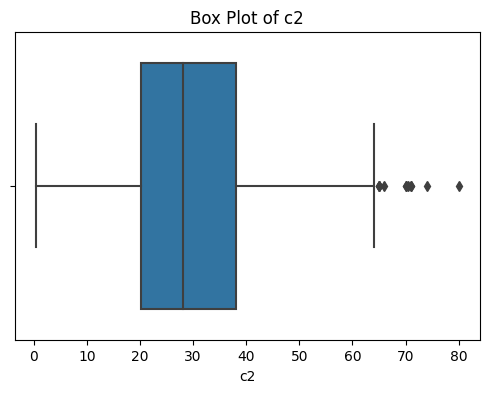

In [11]:
# Visualizing first-in-order numerical feature using a boxplot.

first_feature = numerical_features[0]   # feature c2
print(first_feature)

# Creating a box plot.
plt.figure(figsize=(6, 4))
sns.boxplot(x=df[first_feature])
plt.title(f"Box Plot of {first_feature}")
plt.xlabel(first_feature)
plt.show()

#### Categorical Features

In [12]:
# The Categorical Features are the ones that are not numerical.
list_categorical_features = df.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("Categorical Features:", list_categorical_features)


Categorical Features: ['c1', 'c5', 'c6', 'c7', 'c8', 'c9']


Binary Features: ['c1']
Ordinal Features: ['c8']
Nominal Features: ['c5', 'c6', 'c7', 'c9']

Count of Categories for Each Categorical Feature:
 c1      2
c5    681
c6    147
c7      3
c8      3
c9    891
dtype: int64


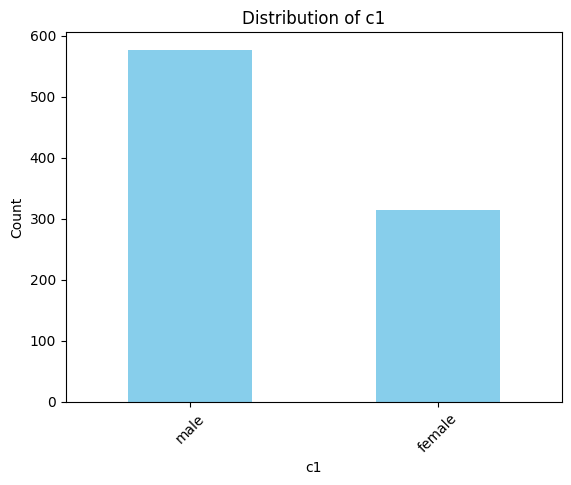

In [13]:
# The Categorical Features are the ones that are not numerical.
list_categorical_features = df.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

# Identify binary, nominal, and ordinal features
binary_features = [col for col in list_categorical_features if df[col].nunique() == 2]

ordinal_features = [col for col in list_categorical_features if df[col].dtype.name == 'category']

# If Python misinterprets c8, add it manually.
if 'c8' in list_categorical_features and 'c8' not in ordinal_features:
    ordinal_features.append('c8')

nominal_features = [col for col in list_categorical_features if col not in binary_features + ordinal_features]
 
print("Binary Features:", binary_features)
print("Ordinal Features:", ordinal_features)
print("Nominal Features:", nominal_features)

# Summarizing count of features.
category_counts = df[list_categorical_features].nunique()
print("\nCount of Categories for Each Categorical Feature:\n", category_counts)

first_categorical_feature = list_categorical_features[0]
df[first_categorical_feature].value_counts().plot(kind='bar', color='skyblue')

plt.title(f'Distribution of {first_categorical_feature}')
plt.xlabel(first_categorical_feature)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Q3: Correlation Analysis 

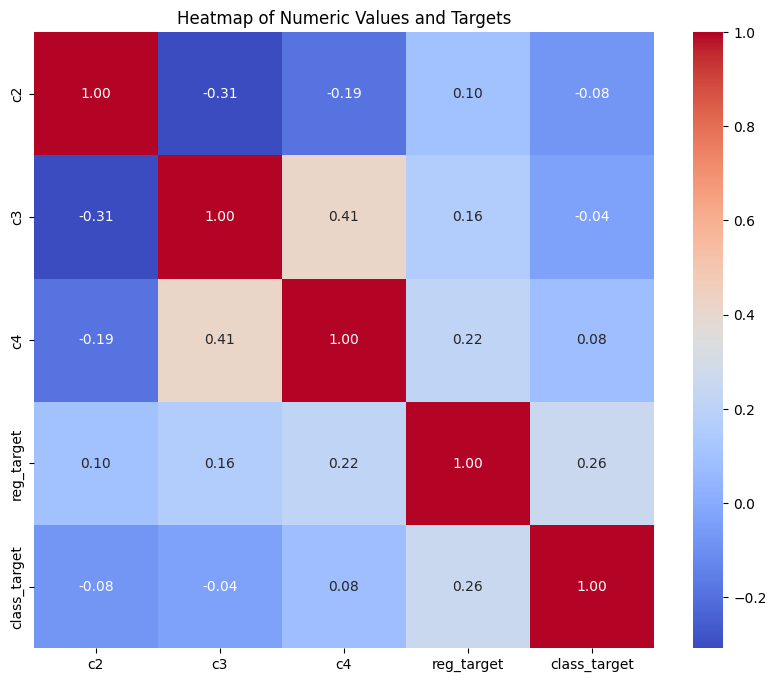

In [14]:
# Concatenate the numerical features with the additional features
correlation_features = df[numerical_features]

# Calculate the correlation matrix
correlation_matrix = correlation_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title("Heatmap of Numeric Values and Targets")
plt.show()

## Part 2: Data Preprocessing Techniques

#### [Q4] Handling missing values

Remove c6
Use median/mean on the other missing columns

In [15]:
# Checking proportion of missing values. 
missing_proportion = df.isnull().mean() * 100
print("Proportion of Missing Values for Each Feature:")
print(missing_proportion)

# Highlighting features with more than 70% missing values.
high_missing_features = missing_proportion[missing_proportion >= 70]
print("\nFeatures with ≥ 70% Missing Values:")
print(high_missing_features)

Proportion of Missing Values for Each Feature:
c1               0.000000
c2              19.865320
c3               0.000000
c4               0.000000
c5               0.000000
c6              77.104377
c7               0.224467
c8               0.000000
c9               0.000000
reg_target       0.000000
class_target     0.000000
dtype: float64

Features with ≥ 70% Missing Values:
c6    77.104377
dtype: float64


In [16]:
# Dropping feature c6 because it has >70% NaN values
df = df.drop(["c6"], axis=1)

# Median imputation for c2 because it has a moderate amount of missing values.
median_imputer = SimpleImputer(strategy='median')
df['c2'] = median_imputer.fit_transform(df[['c2']])

# Mode imputation for c7 because it has a small amount of missing values.
mode_imputer = SimpleImputer(strategy='most_frequent')
df['c7'] = mode_imputer.fit_transform(df[['c7']]).ravel()

# No more missing values.
print(df.isna().sum())


c1              0
c2              0
c3              0
c4              0
c5              0
c7              0
c8              0
c9              0
reg_target      0
class_target    0
dtype: int64


#### [Q5] Normalization and Standardization of first-in-order feature

In [17]:
first_feature = 'c2' # first in order numerical feature. 

print("Before processing:")
print(df[first_feature].head(10))

# Create a new dataframe that will not include the scaled values
df_scaled = df.copy()  # Create a copy of the original dataframe

standard_scaler = StandardScaler()
df_scaled[first_feature + '_standard'] = standard_scaler.fit_transform(df[[first_feature]])

minmax_scaler = MinMaxScaler()
df_scaled[first_feature + '_minmax'] = minmax_scaler.fit_transform(df[[first_feature]])

robust_scaler = RobustScaler()
df_scaled[first_feature + '_robust'] = robust_scaler.fit_transform(df[[first_feature]])


# Display the first 10 samples after processing in the new dataframe
print("\nAfter processing with StandardScaler:")
print(df_scaled[first_feature + '_standard'].head(10))

print("\nAfter processing with MinMaxScaler:")
print(df_scaled[first_feature + '_minmax'].head(10))

print("\nAfter processing with RobustScaler:")
print(df_scaled[first_feature + '_robust'].head(10))


print("\nThe new dataframe with scaled features:")
print(df_scaled.head(10))


Before processing:
0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
5    28.0
6    54.0
7     2.0
8    27.0
9    14.0
Name: c2, dtype: float64

After processing with StandardScaler:
0   -0.565736
1    0.663861
2   -0.258337
3    0.433312
4    0.433312
5   -0.104637
6    1.893459
7   -2.102733
8   -0.181487
9   -1.180535
Name: c2_standard, dtype: float64

After processing with MinMaxScaler:
0    0.271174
1    0.472229
2    0.321438
3    0.434531
4    0.434531
5    0.346569
6    0.673285
7    0.019854
8    0.334004
9    0.170646
Name: c2_minmax, dtype: float64

After processing with RobustScaler:
0   -0.461538
1    0.769231
2   -0.153846
3    0.538462
4    0.538462
5    0.000000
6    2.000000
7   -2.000000
8   -0.076923
9   -1.076923
Name: c2_robust, dtype: float64

The new dataframe with scaled features:
       c1    c2  c3  c4                c5 c7            c8  \
0    male  22.0   1   0         A/5 21171  S   Lower Class   
1  female  38.0   1   0          PC 17599  C   Upper Class  

## [Q6] 

#### Removing features with more than 70% unique values.

In [18]:
copy_df = df.copy()

categorical_features = df.select_dtypes(include=["object"])

unique_percentage = categorical_features.nunique() / len(df) * 100

columns_to_drop = unique_percentage[unique_percentage > 70].index

df = df.drop(columns=columns_to_drop)

print("Updated DataFrame:")
(df.head())


Updated DataFrame:


,c1,c2,c3,c4,c7,c8,reg_target,class_target
0,male,22.0,1,0,S,Lower Class,7.2500,0
1,female,38.0,1,0,C,Upper Class,71.2833,1
2,female,26.0,0,0,S,Lower Class,7.9250,1
3,female,35.0,1,0,S,Upper Class,53.1000,1
4,male,35.0,0,0,S,Lower Class,8.0500,0


#### Encoding Categorical Variables

In [19]:
# First in order categorical feature.
print("First-in-order categorical feature (before encoding):")
print(df[['c1']].head(10))

onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)  

encoded_c1 = onehot_encoder.fit_transform(df[['c1']])

encoded_c1_df = pd.DataFrame(encoded_c1, columns=onehot_encoder.get_feature_names_out(['c1']))

# Drop old c1 feature.
df = df.drop(columns=['c1'])

df = pd.concat([encoded_c1_df, df], axis=1)

ordinal_columns = ['c8'] 
ordinal_encoder = OrdinalEncoder(categories=[["Lower Class", "Middle Class", "Upper Class"]])
df[ordinal_columns] = ordinal_encoder.fit_transform(df[ordinal_columns])


nominal_columns = ['c7'] 
onehot_encoder_nominal = OneHotEncoder(drop='first', sparse_output=False)
encoded_nominal = onehot_encoder_nominal.fit_transform(df[nominal_columns])


encoded_nominal_df = pd.DataFrame(encoded_nominal, columns=onehot_encoder_nominal.get_feature_names_out(nominal_columns))

df = df.drop(columns=nominal_columns)
df = pd.concat([df, encoded_nominal_df], axis=1)


print("\nFirst-in-order categorical feature (after encoding):")
print(df[['c1_male']].head(10))

First-in-order categorical feature (before encoding):
       c1
0    male
1  female
2  female
3  female
4    male
5    male
6    male
7    male
8  female
9  female

First-in-order categorical feature (after encoding):
   c1_male
0      1.0
1      0.0
2      0.0
3      0.0
4      1.0
5      1.0
6      1.0
7      1.0
8      0.0
9      0.0


In [20]:
'''
# Step 3: Handle Ordinal and Nominal Features
# Define your ordinal features and their correct order (if needed)
ordinal_features = ['c8']  # Replace with actual ordinal features
ordinal_encoder = OrdinalEncoder(categories=[['Lower Class', 'Middle Class', 'Upper Class']])  # Example ordinal categories

# Initialize OneHotEncoder for nominal features (without dropping the first column to avoid multicollinearity)
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' to avoid multicollinearity

# Apply OrdinalEncoder to ordinal features
df[ordinal_features] = ordinal_encoder.fit_transform(df[ordinal_features])

# Apply OneHotEncoder to nominal features
nominal_features = [col for col in df.columns if col not in ordinal_features]
df_nominal_encoded = onehot_encoder.fit_transform(df[nominal_features])

# Convert the encoded nominal features back to a DataFrame and append to df
df_nominal_encoded_df = pd.DataFrame(df_nominal_encoded, columns=onehot_encoder.get_feature_names_out(nominal_features))

# Convert all the one-hot encoded columns to integer type
df_nominal_encoded_df = df_nominal_encoded_df.astype(int)

# Drop original nominal columns and join the new one-hot encoded columns
df = df.drop(nominal_features, axis=1).join(df_nominal_encoded_df)

# Step 4: Report the first-in-order categorical feature column before and after processing
before_processing = categorical_features.head(10)  # First 10 rows before encoding
after_processing = df.head(10)  # First 10 rows after encoding

# Ensure the first categorical column exists before and after processing
first_categorical_column_before = categorical_features.columns[0]

# Show the first categorical feature column before and after processing
if first_categorical_column_before in before_processing.columns:
    before = before_processing[first_categorical_column_before]
else:
    before = None

after_columns = [col for col in after_processing.columns if first_categorical_column_before in col]
after = after_processing[after_columns].iloc[:, 0] if after_columns else None

before, after
'''


"\n# Step 3: Handle Ordinal and Nominal Features\n# Define your ordinal features and their correct order (if needed)\nordinal_features = ['c8']  # Replace with actual ordinal features\nordinal_encoder = OrdinalEncoder(categories=[['Lower Class', 'Middle Class', 'Upper Class']])  # Example ordinal categories\n\n# Initialize OneHotEncoder for nominal features (without dropping the first column to avoid multicollinearity)\nonehot_encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' to avoid multicollinearity\n\n# Apply OrdinalEncoder to ordinal features\ndf[ordinal_features] = ordinal_encoder.fit_transform(df[ordinal_features])\n\n# Apply OneHotEncoder to nominal features\nnominal_features = [col for col in df.columns if col not in ordinal_features]\ndf_nominal_encoded = onehot_encoder.fit_transform(df[nominal_features])\n\n# Convert the encoded nominal features back to a DataFrame and append to df\ndf_nominal_encoded_df = pd.DataFrame(df_nominal_encoded, columns=one

#### [Q7] Future Engineering

In [21]:
# Extracting tiles from feature c9.
def extract_titles(name):
    titles = ['Mr', 'Mrs', 'Master', 'Miss']
    
    title_dict = {title: 0 for title in titles}
    
    for title in titles:
        if re.search(r'\b' + title + r'\b', name):  
            title_dict[title] = 1
    
    return title_dict

title_columns = copy_df['c9'].apply(extract_titles).apply(pd.Series)

copy_df = pd.concat([copy_df, title_columns], axis=1)

onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_c1 = onehot_encoder.fit_transform(copy_df[['c1']])


encoded_c1_df = pd.DataFrame(encoded_c1, columns=onehot_encoder.get_feature_names_out(['c1']))

df_copy = pd.concat([copy_df, encoded_c1_df], axis=1)
df_copy = df_copy.drop(columns=['c1'])

df = pd.concat([df, title_columns], axis=1)

df.head()

,c1_male,c2,c3,c4,c8,reg_target,class_target,c7_Q,c7_S,Mr,Mrs,Master,Miss
0,1.0,22.0,1,0,0.0,7.2500,0,0.0,1.0,1,0,0,0
1,0.0,38.0,1,0,2.0,71.2833,1,0.0,0.0,0,1,0,0
2,0.0,26.0,0,0,0.0,7.9250,1,0.0,1.0,0,0,0,1
3,0.0,35.0,1,0,2.0,53.1000,1,0.0,1.0,0,1,0,0
4,1.0,35.0,0,0,0.0,8.0500,0,0.0,1.0,1,0,0,0


## Part 3: Regression

In [22]:
seed = 4211

# All features except target variables.
X = df.drop(columns=["reg_target", "class_target"])

# target variable in regression model.
y = df["reg_target"] 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

# Check the shapes of the resulting sets
print("Training set features shape:", X_train.shape)
print("Validation set features shape:", X_val.shape)
print("Training set target shape:", y_train.shape)
print("Validation set target shape:", y_val.shape)

Training set features shape: (712, 11)
Validation set features shape: (179, 11)
Training set target shape: (712,)
Validation set target shape: (179,)


#### First step: Building Linear Regression models

In [23]:
features = ['c2', "c3", "c4", 'c8']  # c2, c3 and c4 are numerical, c8 is ordinal.
results = {}

for feature in features:
    X_feature = X_train[[feature]] 
    y_train_copy = y_train

    model = LinearRegression()
    model.fit(X_feature, y_train_copy)

    coefficient = model.coef_[0]
    intercept = model.intercept_

    r_squared = model.score(X_feature, y_train_copy)

    # Relevant results.
    results[feature] = {
        'coefficient': coefficient,
        'intercept': intercept,
        'r_squared': r_squared
    }
    
print("\n------------------TRAINING DATA RESULTS---------------------\n")
for feature, result in results.items():
    print(f"Feature: {feature}")
    print(f"  Coefficient: {result['coefficient']}")
    print(f"  Intercept: {result['intercept']}")
    print(f"  R-squared: {result['r_squared']}\n")


------------------TRAINING DATA RESULTS---------------------

Feature: c2
  Coefficient: 0.33672536610463094
  Intercept: 21.151519122556017
  R-squared: 0.009252051027266006

Feature: c3
  Coefficient: 7.418973581932179
  Intercept: 26.912830725601662
  R-squared: 0.030946940341159745

Feature: c4
  Coefficient: 11.65861905971901
  Intercept: 26.217579596462762
  R-squared: 0.044368602709245364

Feature: c8
  Coefficient: 30.68182406597961
  Intercept: 10.281798663384532
  R-squared: 0.29903490904184027



#### Combining ordinal and numerical features to make two linear regression models

In [24]:
# Prepare the feature matrix X_all (all selected features) and target variable y
X_all = X_train[features]  # Use the training features
y_train_copy = y_train  # Target variable

# Initialize and fit the model using all the features
model_all_features = LinearRegression()
model_all_features.fit(X_all, y_train_copy)

# Make predictions on the training data
y_train_pred_all = model_all_features.predict(X_all)

# Calculate R-squared to evaluate how well the model fits the data
r_squared_all = model_all_features.score(X_all, y_train_copy)

# Calculate Mean Squared Error (optional, for model evaluation)
mse_all = mean_squared_error(y_train_copy, y_train_pred_all)

print("\n------------------TRAINING DATA RESULTS---------------------\n")

# Display the results
print("Model with all features:")
print(f"  Coefficients: {model_all_features.coef_}")
print(f"  Intercept: {model_all_features.intercept_}")
print(f"  R-squared: {r_squared_all}")
print(f"  Mean Squared Error (MSE): {mse_all}")


------------------TRAINING DATA RESULTS---------------------

Model with all features:
  Coefficients: [-0.13109071  6.45782286  8.70055326 32.3241762 ]
  Intercept: 5.923557740114202
  R-squared: 0.3714887944113733
  Mean Squared Error (MSE): 1357.229039590777


#### [Q8] Results on validation data.

In [25]:
validation_results = {}

for feature in features:
    X_val_feature = X_val[[feature]]  
    y_val_copy = y_val 

    model = LinearRegression()
    model.fit(X_train[[feature]], y_train)

    y_val_pred = model.predict(X_val_feature)

    r_squared_val = model.score(X_val_feature, y_val_copy)
    mse_val = mean_squared_error(y_val_copy, y_val_pred)

    validation_results[feature] = {
        'r_squared': r_squared_val,
        'mse': mse_val
    }

print("\n------------------VALIDATION DATA RESULTS---------------------\n")

for model_number, (feature, result) in enumerate(validation_results.items(), start=1):

    # Relevant results. 
    print(f'Regression Model {model_number}')
    print(f"Feature: {feature}")
    print(f"  R-squared: {result['r_squared']:.4f}")  
    print(f"  Mean Squared Error (MSE): {result['mse']:.4f}\n")  


X_train_all = X_train[features]
X_val_all = X_val[features]

combined_model = LinearRegression()
combined_model.fit(X_train_all, y_train)

y_val_pred_combined = combined_model.predict(X_val_all)

r_squared_combined = combined_model.score(X_val_all, y_val)
mse_combined = mean_squared_error(y_val, y_val_pred_combined)


# Reporting results on validation data.
print("Combined model with all features:")
print(f"  R-squared: {r_squared_combined}")
print(f"  Mean Squared Error (MSE): {mse_combined}")


------------------VALIDATION DATA RESULTS---------------------

Regression Model 1
Feature: c2
  R-squared: -0.0007
  Mean Squared Error (MSE): 3661.0534

Regression Model 2
Feature: c3
  R-squared: 0.0018
  Mean Squared Error (MSE): 3651.8049

Regression Model 3
Feature: c4
  R-squared: 0.0388
  Mean Squared Error (MSE): 3516.5773

Regression Model 4
Feature: c8
  R-squared: 0.2986
  Mean Squared Error (MSE): 2565.9937

Combined model with all features:
  R-squared: 0.3535085801101705
  Mean Squared Error (MSE): 2365.1076480015345


#### [Q9]

In [26]:
updated_features = ["c2", "c3", "c4", "c8", "c7_Q", "c7_S"]  # Now c7 in form of c7_Q and c7_S will be added to the model 


X_train_updated = X_train[updated_features]  
X_val_updated = X_val[updated_features]      

# Importing timer to time model training time.
start_time = time.time()
model_updated = LinearRegression()
model_updated.fit(X_train_updated, y_train)
training_time = time.time() - start_time  

y_val_pred_updated = model_updated.predict(X_val_updated)

r_squared_updated = model_updated.score(X_val_updated, y_val)
mse_updated = mean_squared_error(y_val, y_val_pred_updated)

# Reporting results.
print("\nUpdated regression model with c2, c3, c4, c8, and c7:\n")
print(f"  Training Time: {training_time:.4f} seconds")
print(f"  R-squared: {r_squared_updated:.4f}")
print(f"  Mean Squared Error (MSE): {mse_updated:.4f}")


Updated regression model with c2, c3, c4, c8, and c7:

  Training Time: 0.0000 seconds
  R-squared: 0.3827
  Mean Squared Error (MSE): 2258.4838


##  [Q11] Feedforward Neural Networks


Training model with 1 hidden units...
Training Time: 0.50 seconds
R² Score on Validation Set: -0.3701
Mean Squared Error (MSE): 5012.2734

Training model with 8 hidden units...
Training Time: 0.53 seconds
R² Score on Validation Set: 0.3888
Mean Squared Error (MSE): 2235.8989

Training model with 32 hidden units...
Training Time: 0.24 seconds
R² Score on Validation Set: 0.3946
Mean Squared Error (MSE): 2214.6793

Training model with 128 hidden units...
Training Time: 4.09 seconds
R² Score on Validation Set: 0.3892
Mean Squared Error (MSE): 2234.4316


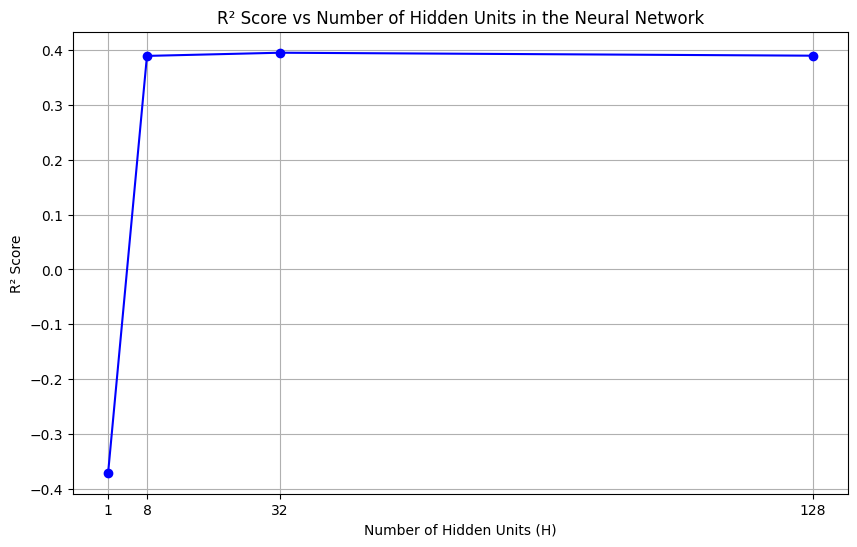

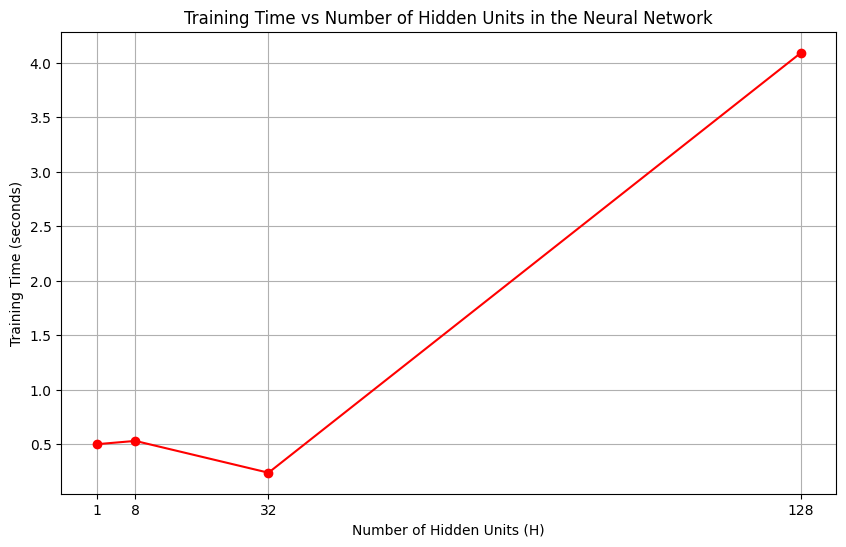

In [27]:
# Features and target variable
features_Q8 = ["c2","c3", "c4", "c8"]
X_train = X_train[features_Q8]  
X_val = X_val[features_Q8]      
y_train = y_train               
y_val = y_val                   


hidden_units_options = [1, 8, 32, 128]
r2_scores = []  
mse_scores = []  
training_times = []

for H in hidden_units_options:
    print(f"\nTraining model with {H} hidden units...")

    model = MLPRegressor(
    hidden_layer_sizes=(H, H, H),
    early_stopping=True,
    max_iter=1000,
    random_state=4211,
    solver='adam',  
    tol=1e-4,  
    n_iter_no_change=10  
)

    start_time = time.time()

    model.fit(X_train, y_train)

    training_time = time.time() - start_time
    training_times.append(training_time)

    y_val_pred = model.predict(X_val)

    r2 = r2_score(y_val, y_val_pred)
    r2_scores.append(r2)

    mse = mean_squared_error(y_val, y_val_pred)
    mse_scores.append(mse)

    print(f"Training Time: {training_time:.2f} seconds")
    print(f"R² Score on Validation Set: {r2:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(hidden_units_options, r2_scores, marker='o', color='b', label='R² Score')
plt.title('R² Score vs Number of Hidden Units in the Neural Network')
plt.xlabel('Number of Hidden Units (H)')
plt.ylabel('R² Score')
plt.grid(True)
plt.xticks(hidden_units_options)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(hidden_units_options, training_times, marker='o', color='r', label='Training Time')
plt.title('Training Time vs Number of Hidden Units in the Neural Network')
plt.xlabel('Number of Hidden Units (H)')
plt.ylabel('Training Time (seconds)')
plt.grid(True)
plt.xticks(hidden_units_options)
plt.show()

# Does not ask to plot MSE results.


## Part 4: Classification

## [Q13 + Q14] 


Logistic Regression Model Results:
  Training Time: 0.0110 seconds
  Accuracy: 0.7263
  F1 Score: 0.6316
  AUC: 0.6928

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.80      0.78       110
           1       0.66      0.61      0.63        69

    accuracy                           0.73       179
   macro avg       0.71      0.70      0.71       179
weighted avg       0.72      0.73      0.72       179



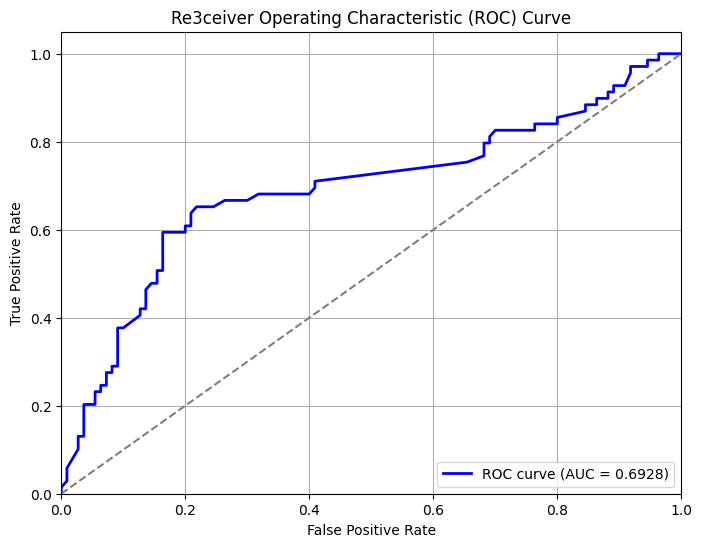

In [28]:
# Relevant features (from Q8).

features_Q8 = ["c2", "c3", "c4", "c8"]  
X = df[features_Q8].values 
y = df["class_target"].values 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4211, stratify=y)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

model = SGDClassifier(loss="log_loss", learning_rate="optimal", eta0=1.0, random_state=4211)

start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred = model.predict(X_val)
y_pred_proba = model.decision_function(X_val)

accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

print("\nLogistic Regression Model Results:")
print(f"  Training Time: {training_time:.4f} seconds")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1 Score: {f1:.4f}")
print(f"  AUC: {roc_auc:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_val, y_pred))

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Re3ceiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## [Q15]

Epoch 1/50


C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6153 - loss: 0.6925 - val_accuracy: 0.6145 - val_loss: 0.6910
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6195 - loss: 0.6905 - val_accuracy: 0.6145 - val_loss: 0.6893
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6207 - loss: 0.6887 - val_accuracy: 0.6145 - val_loss: 0.6875
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6252 - loss: 0.6865 - val_accuracy: 0.6145 - val_loss: 0.6858
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6145 - loss: 0.6853 - val_accuracy: 0.6145 - val_loss: 0.6841
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6143 - loss: 0.6838 - val_accuracy: 0.6145 - val_loss: 0.6827
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6052 - loss: 0.6834 - val_accuracy: 0.6145 - val_loss: 0.6814
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6281 - loss: 0.6795 - val_accuracy: 0.6145 - val_loss: 0.6801
Ep

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6442 - loss: 0.6926 - val_accuracy: 0.6145 - val_loss: 0.6910
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6178 - loss: 0.6905 - val_accuracy: 0.6145 - val_loss: 0.6891
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6418 - loss: 0.6877 - val_accuracy: 0.6145 - val_loss: 0.6873
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6210 - loss: 0.6864 - val_accuracy: 0.6145 - val_loss: 0.6855
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6370 - loss: 0.6834 - val_accuracy: 0.6145 - val_loss: 0.6839
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6107 - loss: 0.6839 - val_accuracy: 0.6145 - val_loss: 0.6825
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6243 - loss: 0.6811 - val_accuracy: 0.6145 - val_loss: 0.6811
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6364 - loss: 0.6781 - val_accuracy: 0.6145 - val_loss: 0.6798
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6128 - loss: 0.6926 - val_accuracy: 0.6145 - val_loss: 0.6910
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6239 - loss: 0.6903 - val_accuracy: 0.6145 - val_loss: 0.6890
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6123 - loss: 0.6886 - val_accuracy: 0.6145 - val_loss: 0.6873
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6001 - loss: 0.6877 - val_accuracy: 0.6145 - val_loss: 0.6858
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6251 - loss: 0.6847 - val_accuracy: 0.6145 - val_loss: 0.6842
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6134 - loss: 0.6840 - val_accuracy: 0.6145 - val_loss: 0.6829
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6131 - loss: 0.6827 - val_accuracy: 0.6145 - val_loss: 0.6816
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6074 - loss: 0.6821 - val_accuracy: 0.6145 - val_loss: 0.6803
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5891 - loss: 0.6940 - val_accuracy: 0.6089 - val_loss: 0.6912
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6199 - loss: 0.6858 - val_accuracy: 0.6145 - val_loss: 0.6813
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6287 - loss: 0.6739 - val_accuracy: 0.6145 - val_loss: 0.6725
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5931 - loss: 0.6763 - val_accuracy: 0.6145 - val_loss: 0.6638
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6430 - loss: 0.6520 - val_accuracy: 0.6145 - val_loss: 0.6557
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6276 - loss: 0.6495 - val_accuracy: 0.6145 - val_loss: 0.6470
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6350 - loss: 0.6382 - val_accuracy: 0.6145 - val_loss: 0.6396
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6542 - loss: 0.6179 - val_accuracy: 0.6145 - val_loss: 0.6326
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3727 - loss: 0.7314 - val_accuracy: 0.4022 - val_loss: 0.6947
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4423 - loss: 0.7012 - val_accuracy: 0.5754 - val_loss: 0.6781
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5604 - loss: 0.6841 - val_accuracy: 0.7151 - val_loss: 0.6669
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6275 - loss: 0.6770 - val_accuracy: 0.7263 - val_loss: 0.6594
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6576 - loss: 0.6716 - val_accuracy: 0.7318 - val_loss: 0.6528
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6792 - loss: 0.6643 - val_accuracy: 0.7318 - val_loss: 0.6474
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6959 - loss: 0.6502 - val_accuracy: 0.7039 - val_loss: 0.6431
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6710 - loss: 0.6561 - val_accuracy: 0.7095 - val_loss: 0.6403
Ep

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5645 - loss: 0.6853 - val_accuracy: 0.6480 - val_loss: 0.6816
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5789 - loss: 0.6797 - val_accuracy: 0.6592 - val_loss: 0.6656
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6189 - loss: 0.6635 - val_accuracy: 0.6704 - val_loss: 0.6523
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6503 - loss: 0.6500 - val_accuracy: 0.7318 - val_loss: 0.6389
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7235 - loss: 0.6368 - val_accuracy: 0.7374 - val_loss: 0.6265
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7159 - loss: 0.6273 - val_accuracy: 0.7263 - val_loss: 0.6152
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7200 - loss: 0.6162 - val_accuracy: 0.7263 - val_loss: 0.6042
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6880 - loss: 0.6225 - val_accuracy: 0.7263 - val_loss: 0.5947
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5763 - loss: 0.6757 - val_accuracy: 0.7151 - val_loss: 0.6188
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6661 - loss: 0.6169 - val_accuracy: 0.7207 - val_loss: 0.5871
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6827 - loss: 0.6113 - val_accuracy: 0.7318 - val_loss: 0.5642
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6875 - loss: 0.5896 - val_accuracy: 0.7318 - val_loss: 0.5578
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7291 - loss: 0.5647 - val_accuracy: 0.7374 - val_loss: 0.5513
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7349 - loss: 0.5653 - val_accuracy: 0.7374 - val_loss: 0.5580
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7210 - loss: 0.5536 - val_accuracy: 0.7263 - val_loss: 0.5617
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7405 - loss: 0.5535 - val_accuracy: 0.7374 - val_loss: 0.5579
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5647 - loss: 0.6765 - val_accuracy: 0.6760 - val_loss: 0.6411
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6656 - loss: 0.6346 - val_accuracy: 0.6983 - val_loss: 0.6030
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7179 - loss: 0.5830 - val_accuracy: 0.7263 - val_loss: 0.5868
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7417 - loss: 0.5569 - val_accuracy: 0.7318 - val_loss: 0.5731
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7306 - loss: 0.5666 - val_accuracy: 0.7430 - val_loss: 0.5732
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7418 - loss: 0.5577 - val_accuracy: 0.7318 - val_loss: 0.5781
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7235 - loss: 0.5543 - val_accuracy: 0.7207 - val_loss: 0.5695
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7273 - loss: 0.5559 - val_accuracy: 0.7318 - val_loss: 0.5735
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4489 - loss: 0.7071 - val_accuracy: 0.7095 - val_loss: 0.6683
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6893 - loss: 0.6574 - val_accuracy: 0.6927 - val_loss: 0.6400
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6514 - loss: 0.6315 - val_accuracy: 0.7318 - val_loss: 0.6060
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7217 - loss: 0.5792 - val_accuracy: 0.7430 - val_loss: 0.5762
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7278 - loss: 0.5624 - val_accuracy: 0.7486 - val_loss: 0.5579
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7083 - loss: 0.5601 - val_accuracy: 0.7430 - val_loss: 0.5627
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7278 - loss: 0.5468 - val_accuracy: 0.7374 - val_loss: 0.5631
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7556 - loss: 0.5256 - val_accuracy: 0.7374 - val_loss: 0.5647
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6915 - loss: 0.6422 - val_accuracy: 0.7374 - val_loss: 0.5684
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7214 - loss: 0.5681 - val_accuracy: 0.7486 - val_loss: 0.5503
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7497 - loss: 0.5416 - val_accuracy: 0.7374 - val_loss: 0.5676
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7471 - loss: 0.5474 - val_accuracy: 0.7318 - val_loss: 0.5546
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7125 - loss: 0.5677 - val_accuracy: 0.7430 - val_loss: 0.5651
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7304 - loss: 0.5459 - val_accuracy: 0.7318 - val_loss: 0.5746
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7410 - loss: 0.5338 - val_accuracy: 0.7374 - val_loss: 0.5812
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 1/50


C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6286 - loss: 0.6438 - val_accuracy: 0.7486 - val_loss: 0.5650
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7024 - loss: 0.5945 - val_accuracy: 0.7374 - val_loss: 0.5687
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7279 - loss: 0.5828 - val_accuracy: 0.7318 - val_loss: 0.5631
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7158 - loss: 0.5749 - val_accuracy: 0.7430 - val_loss: 0.5603
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7196 - loss: 0.5441 - val_accuracy: 0.7263 - val_loss: 0.5736
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7369 - loss: 0.5247 - val_accuracy: 0.7318 - val_loss: 0.5689
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7083 - loss: 0.5892 - val_accuracy: 0.7318 - val_loss: 0.5679
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7407 - loss: 0.5333 - val_accuracy: 0.6927 - val_loss: 0.5897
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6452 - loss: 0.6426 - val_accuracy: 0.7374 - val_loss: 0.5646
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7077 - loss: 0.5651 - val_accuracy: 0.7374 - val_loss: 0.5747
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6991 - loss: 0.5853 - val_accuracy: 0.7374 - val_loss: 0.5733
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7231 - loss: 0.5576 - val_accuracy: 0.7318 - val_loss: 0.5728
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7454 - loss: 0.5325 - val_accuracy: 0.7374 - val_loss: 0.5857
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7326 - loss: 0.5589 - val_accuracy: 0.7263 - val_loss: 0.5688
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


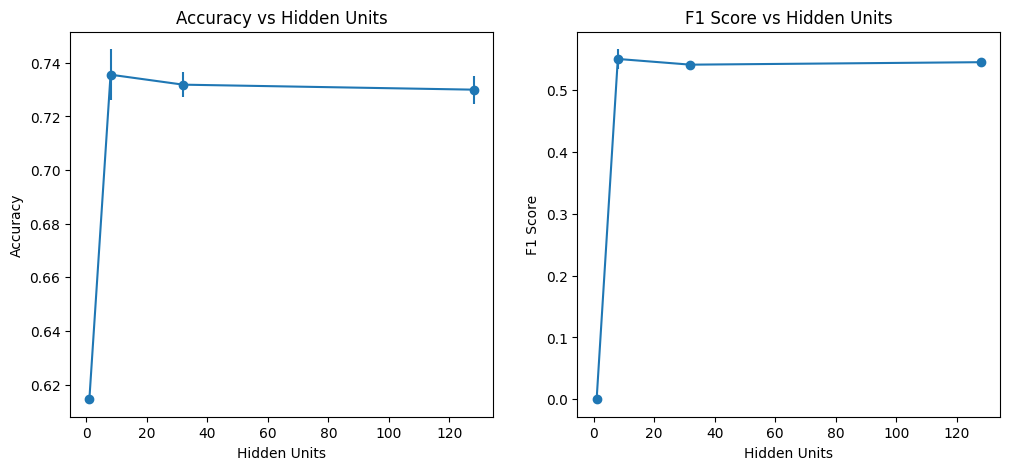

H=1: Accuracy=0.6145 ± 0.0000, F1=0.0000 ± 0.0000, Training Time=6.3794 ± 0.5069 sec
H=8: Accuracy=0.7356 ± 0.0095, F1=0.5506 ± 0.0157, Training Time=4.8784 ± 1.1993 sec
H=32: Accuracy=0.7318 ± 0.0046, F1=0.5414 ± 0.0059, Training Time=2.0486 ± 0.0910 sec
H=128: Accuracy=0.7300 ± 0.0053, F1=0.5454 ± 0.0036, Training Time=1.6298 ± 0.1190 sec


In [29]:
# Hidden layers to be tested. 
hidden_units = [1, 8, 32, 128]

results = {}

for H in hidden_units:
    train_times, accuracies, f1_scores = [], [], []

    # repeat setting three times. 
    for _ in range(3):  
        model = keras.Sequential([
            layers.Dense(H, activation='relu', input_shape=(X_train.shape[1],)),
            layers.Dense(H, activation='relu'),
            layers.Dense(H, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        
        start_time = time.time()

        # Using keras for modern deep learning.
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                  callbacks=[keras.callbacks.EarlyStopping(patience=5)])
        train_time = time.time() - start_time
        
        y_pred = (model.predict(X_val) > 0.5).astype(int)
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        
        train_times.append(train_time)
        accuracies.append(accuracy)
        f1_scores.append(f1)
    
    results[H] = {
        'train_time_mean': np.mean(train_times), 'train_time_std': np.std(train_times),
        'accuracy_mean': np.mean(accuracies), 'accuracy_std': np.std(accuracies),
        'f1_mean': np.mean(f1_scores), 'f1_std': np.std(f1_scores)
    }


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].errorbar(hidden_units, [results[H]['accuracy_mean'] for H in hidden_units],
               yerr=[results[H]['accuracy_std'] for H in hidden_units], label='Accuracy', fmt='-o')
ax[1].errorbar(hidden_units, [results[H]['f1_mean'] for H in hidden_units],
               yerr=[results[H]['f1_std'] for H in hidden_units], label='F1 Score', fmt='-o')
ax[0].set_title("Accuracy vs Hidden Units")
ax[1].set_title("F1 Score vs Hidden Units")
ax[0].set_xlabel("Hidden Units")
ax[1].set_xlabel("Hidden Units")
ax[0].set_ylabel("Accuracy")
ax[1].set_ylabel("F1 Score")
plt.show()

for H, res in results.items():
    print(f"H={H}: Accuracy={res['accuracy_mean']:.4f} ± {res['accuracy_std']:.4f}, "
          f"F1={res['f1_mean']:.4f} ± {res['f1_std']:.4f}, "
          f"Training Time={res['train_time_mean']:.4f} ± {res['train_time_std']:.4f} sec")


## [Q17]

Epoch 1/50


C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6151 - loss: 0.6924 - val_accuracy: 0.6145 - val_loss: 0.6909
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6221 - loss: 0.6904 - val_accuracy: 0.6145 - val_loss: 0.6893
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6235 - loss: 0.6885 - val_accuracy: 0.6145 - val_loss: 0.6874
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6252 - loss: 0.6865 - val_accuracy: 0.6145 - val_loss: 0.6859
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5706 - loss: 0.6886 - val_accuracy: 0.6145 - val_loss: 0.6846
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6064 - loss: 0.6849 - val_accuracy: 0.6145 - val_loss: 0.6831
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6130 - loss: 0.6829 - val_accuracy: 0.6145 - val_loss: 0.6818
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6202 - loss: 0.6807 - val_accuracy: 0.6145 - val_loss: 0.6804
Epo

C:\Users\andre\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6193 - loss: 0.6492 - val_accuracy: 0.7374 - val_loss: 0.5681
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7374 - loss: 0.5528 - val_accuracy: 0.7430 - val_loss: 0.5714
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7083 - loss: 0.5686 - val_accuracy: 0.7374 - val_loss: 0.5795
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7128 - loss: 0.5476 - val_accuracy: 0.7374 - val_loss: 0.5586
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7216 - loss: 0.5623 - val_accuracy: 0.7263 - val_loss: 0.5736
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7314 - loss: 0.5550 - val_accuracy: 0.7263 - val_loss: 0.5758
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7249 - loss: 0.5469 - val_accuracy: 0.7263 - val_loss: 0.5713
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7080 - loss: 0.5723 - val_accuracy: 0.7263 - val_loss: 0.5782
Epo

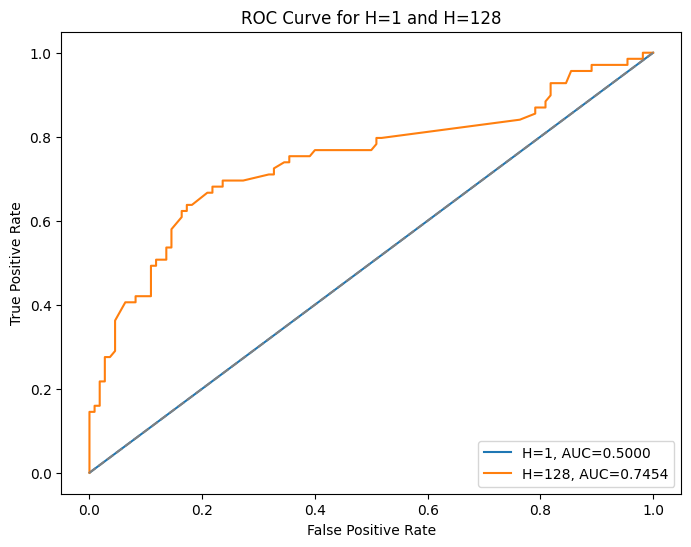

In [30]:
# Relvant hidden layer sizes.
hidden_layer_sizes = [1, 128]

roc_data = {}

for H in hidden_layer_sizes:
    model = keras.Sequential([
        layers.Dense(H, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(H, activation='relu'),
        layers.Dense(H, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=5)])
    
    y_prob = model.predict(X_val)
    
    fpr, tpr, thresholds = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    
    roc_data[H] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

plt.figure(figsize=(8, 6))
for H in hidden_layer_sizes:
    plt.plot(roc_data[H]['fpr'], roc_data[H]['tpr'], label=f'H={H}, AUC={roc_data[H]["auc"]:.4f}')
    
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for H=1 and H=128')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Bonus

#### [Q18]

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.74      0.79       104
           1       0.70      0.83      0.76        75

    accuracy                           0.78       179
   macro avg       0.78      0.78      0.77       179
weighted avg       0.79      0.78      0.78       179



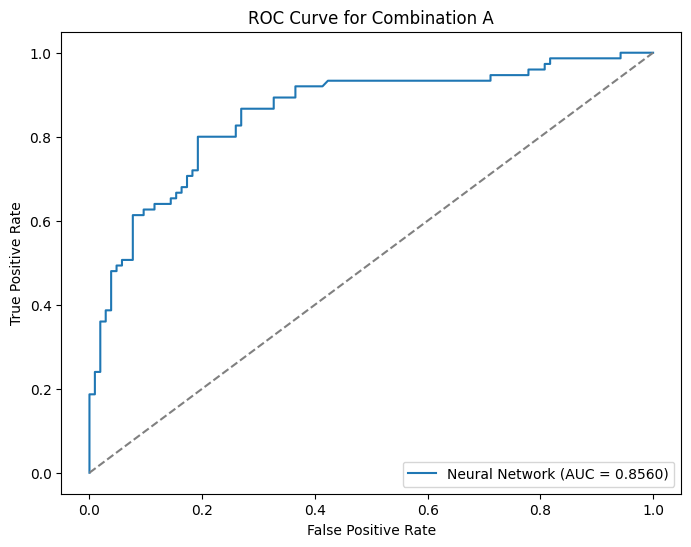

In [31]:
X = bonus_df.drop('class_target', axis=1) 
y = bonus_df['class_target'] 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4211)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Pipeline for numerical features.
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler()),
])

# Pipeline for categorical features.
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combining the pipelines.
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Combining preprocessor pipeline and MLPClassifier. 
nn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(128, 128, 128), max_iter=500, random_state=4211))
])


nn_pipeline.fit(X_train, y_train)
nn_predictions = nn_pipeline.predict(X_val)
nn_report = classification_report(y_val, nn_predictions)
print("Neural Network Classification Report:")
print(nn_report)

nn_prob = nn_pipeline.predict_proba(X_val)[:, 1] 
fpr_nn, tpr_nn, _ = roc_curve(y_val, nn_prob)
roc_auc_nn = auc(fpr_nn, tpr_nn)


plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.title('ROC Curve for Combination A')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## [Q19]

Accuracy: 0.7932960893854749

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       104
           1       0.72      0.83      0.77        75

    accuracy                           0.79       179
   macro avg       0.79      0.80      0.79       179
weighted avg       0.80      0.79      0.79       179



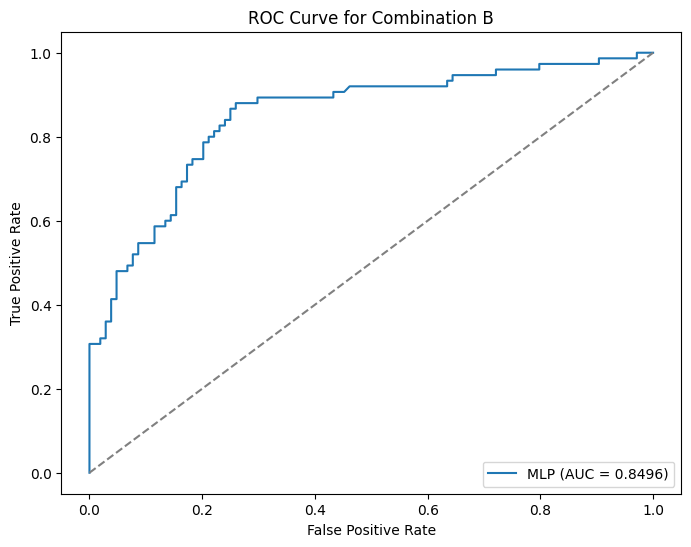

In [32]:
X = bonus_df.drop(columns=['class_target'])
y = bonus_df['class_target']

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Pipeline for numerical features.
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# Pipeline for categorical features.
categorical_pipeline = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combining the pipelines.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Combining preprocessor pipeline and MLPClassifier. 
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(random_state=4211, hidden_layer_sizes=(100, 100, 100), max_iter=500))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4211)

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

y_prob = model_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MLP (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for Combination B')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## [Q20]

Accuracy: 0.7821229050279329

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       104
           1       0.76      0.71      0.73        75

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



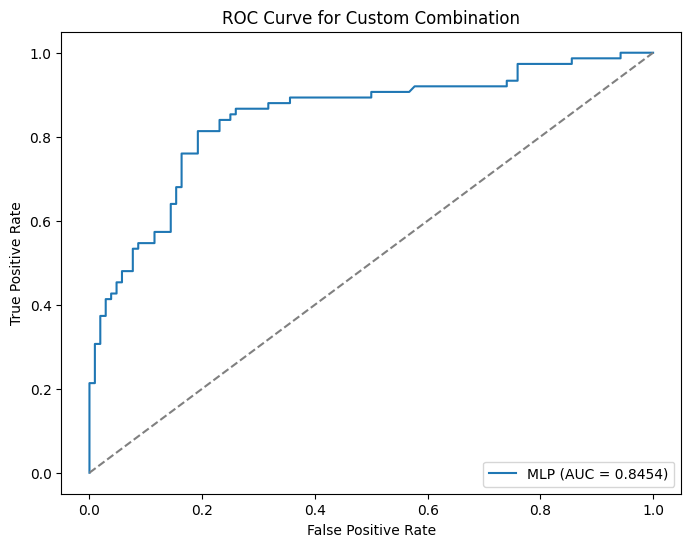

In [33]:
X = bonus_df.drop(columns=['class_target'])
y = bonus_df['class_target']

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()) 
])

categorical_pipeline = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

feature_selection_pipeline = Pipeline(steps=[
    ('variance_threshold', VarianceThreshold(threshold=0.01))  
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection_pipeline),
    ('classifier', MLPClassifier(random_state=4211, hidden_layer_sizes=(100, 100, 100), max_iter=500))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4211)

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

y_prob = model_pipeline.predict_proba(X_test)[:, 1]   
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MLP (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve for Custom Combination')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## [Q21]

In [34]:
X = bonus_df.drop(columns=['class_target'])
y = bonus_df['class_target']

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
    ('scaler', StandardScaler()) 
])

categorical_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

mlp = MLPClassifier(random_state=4211, early_stopping=True)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', mlp)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4211)

param_grid = {
    'classifier__hidden_layer_sizes': [(64, 64, 64), (128, 128, 128), (100, 100, 100), (256, 128, 64)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

top5_results = results[['params', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False).head(5)
print("Top 5 Hyperparameter Settings:")
print(top5_results)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"\nBest Hyperparameter Setting: {best_params}")
print(f"Test Accuracy of Best Model: {test_accuracy:.4f}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Top 5 Hyperparameter Settings:
                                               params  mean_test_score  \
10  {'classifier__activation': 'relu', 'classifier...         0.806107   
8   {'classifier__activation': 'relu', 'classifier...         0.806107   
24  {'classifier__activation': 'relu', 'classifier...         0.803270   
26  {'classifier__activation': 'relu', 'classifier...         0.803270   
0   {'classifier__activation': 'relu', 'classifier...         0.803270   

    std_test_score  
10        0.035567  
8         0.035567  
24        0.047465  
26        0.047465  
0         0.038217  

Best Hyperparameter Setting: {'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100, 100, 100), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam'}
Test Accuracy of Best Model: 0.7989
